In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from pandas import Series

In [3]:
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
from numpy import newaxis

In [8]:
AAPL_data = ystockquote.get_historical_prices('IBM', '2010-01-01', '2017-12-31')

In [9]:
df = pd.DataFrame(AAPL_data).transpose()

In [10]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
2010-01-04,111.405,132.449997,132.970001,130.850006,131.179993,6155300
2010-01-05,110.059232,130.850006,131.850006,130.100006,131.679993,6841400
2010-01-06,109.344283,130.00,131.490005,129.809998,130.679993,5605300
2010-01-07,108.965786,129.550003,130.25,128.910004,129.869995,5840600
2010-01-08,110.059232,130.850006,130.919998,129.050003,129.070007,4197200


In [11]:
df['Date'] = df.apply(lambda row: datetime.strptime(row.name, '%Y-%m-%d'),
                      axis=1)

In [12]:
df['Close'] = pd.to_numeric(df['Close'], errors='ignore')

In [13]:
df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close', 'Date']], inplace=True)

In [14]:
df.set_index('Date', inplace=True)
df.head(3)

,Close
Date,
2010-01-04,132.449997
2010-01-05,130.850006
2010-01-06,130.000000


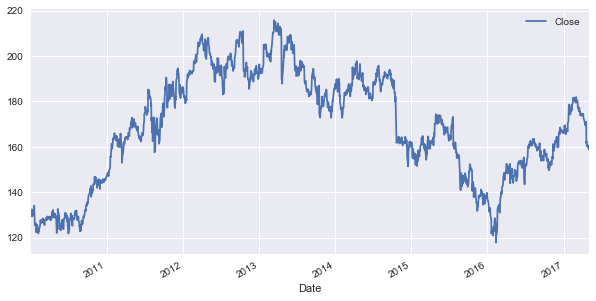

In [15]:
df.plot(figsize=(10,5))

## A rolling forecast scenario will be used, also called walk-forward model validation.

In [16]:
df['Close 1'] = df['Close'].shift(1)

In [17]:
df['Close -1'] = df['Close'].shift(-1)

In [18]:
df.fillna(0, inplace=True)

In [19]:
df['Difference'] = df['Close -1'] - df['Close']

In [20]:
df.head()

,Close,Close 1,Close -1,Difference
Date,,,,
2010-01-04,132.449997,0.000000,130.850006,-1.599991
2010-01-05,130.850006,132.449997,130.000000,-0.850006
2010-01-06,130.000000,130.850006,129.550003,-0.449997
2010-01-07,129.550003,130.000000,130.850006,1.300003
2010-01-08,130.850006,129.550003,129.479996,-1.370010


In [21]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_X = scaler.fit_transform(df['Difference'].values.reshape(-1, 1))

In [22]:
# split data into train and test
length_of_X = len(scaled_X)
train_size = 0.75

to_idx = int(length_of_X*train_size)
train, test = scaled_X[0:to_idx], scaled_X[to_idx:]

In [23]:
print(train.shape)
print(test.shape)

(1383, 1)
(462, 1)


In [99]:
def create_trainable_data(from_data, sequence_length=100):
    result = []
    y_result = []
    for index in range(len(from_data) - sequence_length):
        result.append(from_data[index: index + sequence_length])
        y_result.append(from_data[index + sequence_length])
    result = np.array(result)
    y_result = np.array(y_result)
    return result, y_result

In [100]:
X_train, y_train = create_trainable_data(train)
X_test, y_test = create_trainable_data(test)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X train shape:  (1283, 100, 1)
y train shape:  (1283, 1)


In [101]:
# the second row's last item...
X_train[1, 99, 0]

0.86913560807017354

In [102]:
# ...should be the first predicted value
y_train[0][0]

0.86913560807017354

In [106]:
model = Sequential()
model.add(LSTM(
        input_dim=1,
        output_dim=50,
        return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
        100,
        return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['mae', 'mse'])

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test),
    verbose=2
)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`


Train on 1283 samples, validate on 362 samples
Epoch 1/10
13s - loss: 0.1544 - mean_absolute_error: 0.3408 - mean_squared_error: 0.1544 - val_loss: 0.0273 - val_mean_absolute_error: 0.1405 - val_mean_squared_error: 0.0273
Epoch 2/10
11s - loss: 0.0106 - mean_absolute_error: 0.0947 - mean_squared_error: 0.0106 - val_loss: 0.0133 - val_mean_absolute_error: 0.0666 - val_mean_squared_error: 0.0133
Epoch 3/10
11s - loss: 0.0035 - mean_absolute_error: 0.0500 - mean_squared_error: 0.0035 - val_loss: 0.0110 - val_mean_absolute_error: 0.0409 - val_mean_squared_error: 0.0110
Epoch 4/10
11s - loss: 0.0021 - mean_absolute_error: 0.0362 - mean_squared_error: 0.0021 - val_loss: 0.0104 - val_mean_absolute_error: 0.0283 - val_mean_squared_error: 0.0104
Epoch 5/10
11s - loss: 0.0013 - mean_absolute_error: 0.0279 - mean_squared_error: 0.0013 - val_loss: 0.0102 - val_mean_absolute_error: 0.0232 - val_mean_squared_error: 0.0102
Epoch 6/10
11s - loss: 0.0011 - mean_absolute_error: 0.0253 - mean_squared_err

In [116]:
predicted = model.predict(X_test)

In [123]:
compare = pd.DataFrame([y_test[:,0], predicted[:,0]]).transpose()

In [127]:
compare.head()

,0,1
0,0.884162,0.883901
1,0.875407,0.883984
2,0.887949,0.884003
3,0.893865,0.884031
4,0.904514,0.884088


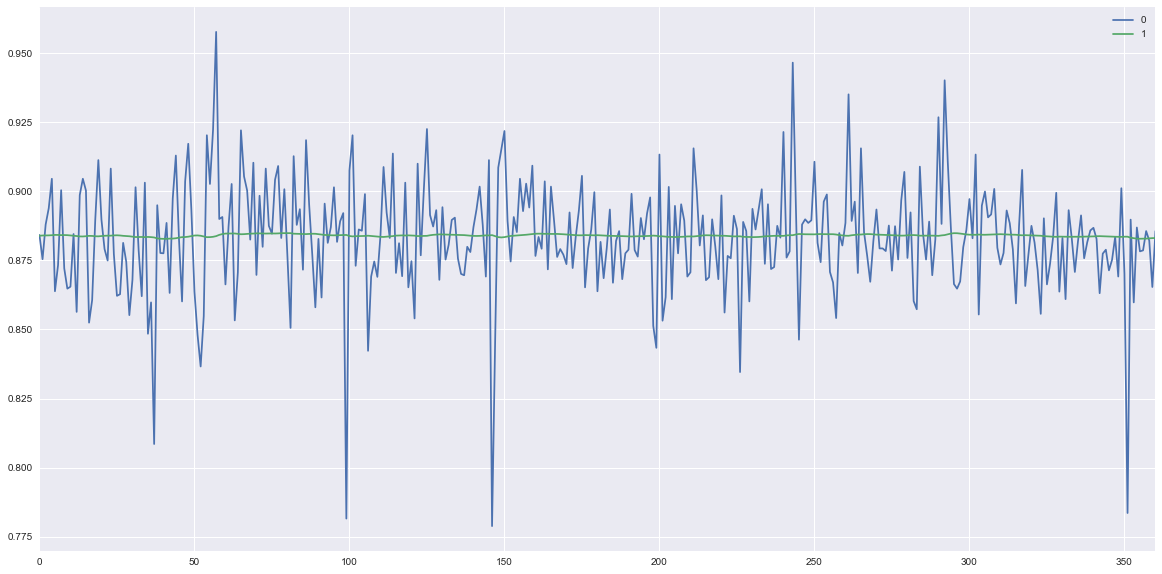

In [129]:
compare[:-1].plot(figsize=(20,10))